# **Evaluate LLM Generation**

Performance evaluation of the RAG system's **generation component** using Azure AI GroundednessEvaluator. Tests whether the LLM correctly uses provided context for grounded questions and refuses to answer when context is insufficient.

### Key Steps:
1. **Load RAG Responses:** Read generated responses from notebook 04
2. **Evaluate Grounded Questions:** Test if LLM answers correctly using provided context
3. **Evaluate Not-Grounded Questions:** Test if LLM refuses to answer when info is missing
4. **Analyze Results:** Compare performance across question types
5. **Error Analysis:** Identify failure patterns for improvement

**Key metrics:** Groundedness scores (1-5), where high scores = good for both question types (answers when possible, refuses when not).

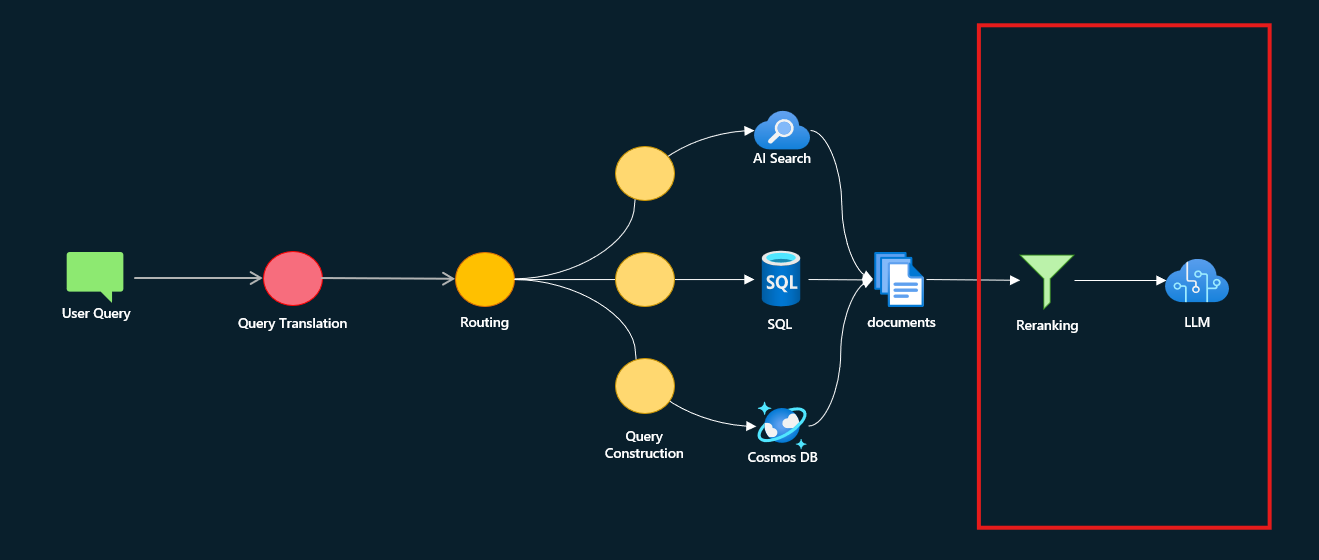

In [51]:
from IPython.display import Image, display
display(Image(filename='media/completion.png', width=1200))

In [1]:
import json
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_context("talk")  # Increase font sizes

import dotenv
dotenv.load_dotenv(".env")

True

## **Read Data**

In [16]:
fpath = f'data/synthetic_samples_with_completion_responses_gpt-4o-mini.csv'
data = pd.read_csv(fpath)

# Deserialize similar_chunks from JSON string
data['similar_chunks'] = data['similar_chunks'].apply(json.loads)

# Split into grounded and not-grounded samples
df_grounded = data[data['is_grounded'] == True].reset_index(drop=True)
df_not_grounded = data[data['is_grounded'] == False].reset_index(drop=True)

print(f"📊 Test Data Split:")
print(f"   Total samples: {len(data)}")
print(f"   Grounded: {len(df_grounded)}")
print(f"   Not grounded: {len(df_not_grounded)}")

df_grounded.head(1)

📊 Test Data Split:
   Total samples: 172
   Grounded: 88
   Not grounded: 84


,synthetic_question,explanation,synthetic_response,chunk_id,synthetic_chunk_id,is_grounded,main_chunk,similar_chunks,domain,difficulty,tone,language,question_length,synthetic_question_embedding,completion_response
0,Vilka storlekar finns Summit Breeze Jacket til...,Frågan handlar om tillgängliga storlekar för S...,Summit Breeze Jacket finns tillgänglig i storl...,c34dafd3cd3a_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,c34dafd3cd3a_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvY...,True,# Information about product item_number: 3\nSu...,[**Storm Flap**: Yes \n**Chin Guard**: Yes \...,Related to Customer,Beginner,Angry,Swedish,19,"[-0.034825511276721954, 0.021744225174188614, ...",Summit Breeze Jacket finns tillgänglig i storl...


## **Evaluate Responses**
Run GroundednessEvaluator on all RAG responses (grounded and not-grounded questions).

In [17]:
# !pip install azure-ai-evaluation==1.0.1 azure-ai-inference azure-ai-projects

In [18]:
def get_model_config():
    return {
        "azure_endpoint": os.getenv("AOAI_ENDPOINT"),
        "api_key": os.getenv("AOAI_KEY"),
        "azure_deployment": os.getenv("chatModel"),
        "api_version": os.getenv("AOAI_API_VERSION")
    }

In [27]:
os.getenv("AZURE_SUBSCRIPTION_ID")

'4ce7ad8d-95ed-4652-bd4a-5f2af19d29cb'

In [38]:
from azure.ai.evaluation import GroundednessEvaluator, GroundednessProEvaluator
from azure.identity import DefaultAzureCredential



def run_custom_groundness_evaluator(
    query: any,
    context: any,
    response: any,
):
    groundedness_eval = GroundednessEvaluator(model_config=get_model_config())
    # groundedness_eval = GroundednessProEvaluator(
    #     azure_ai_project={
    #         "subscription_id": os.getenv("AZURE_SUBSCRIPTION_ID"),
    #         "resource_group_name": os.getenv("AZURE_RESOURCE_GROUP_NAME"),
    #         "project_name": "project-povel",
    #     },
    #     credential=DefaultAzureCredential()
    # )

    groundedness_score = groundedness_eval(
        query=query,
        context=context,
        response=response
    )

    return groundedness_score


In [39]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

def evaluate_row(row):
    # Reconstruct the EXACT same context that was used to generate the response
    main_chunk = row['main_chunk']
    similar_chunks = row['similar_chunks']
    
    context_parts = [f"MAIN CONTEXT:\n{main_chunk}"]
    for i, chunk in enumerate(similar_chunks, 1):
        context_parts.append(f"ADDITIONAL CONTEXT {i}:\n{chunk}")
    
    full_context = "\n\n".join(context_parts)
    
    result = run_custom_groundness_evaluator(
        query=row["synthetic_question"],
        context=full_context,
        response=row["completion_response"]
    )
    return {
        "chunk_id": row["chunk_id"],
        "result": result
    }


def get_predictions(df):
    """
    Process each sample in the provided DataFrame using the custom groundness evaluator,
    and display a single updating progress bar.

    Parameters:
        df (pandas.DataFrame): DataFrame containing the following columns:
            - 'synthetic_question': The question text.
            - 'main_chunk': The main chunk of information.
            - 'similar_chunks': List of similar chunks.
            - 'completion_response': The response to evaluate.

    Returns:
        list: A list of evaluation results in the same order as the input DataFrame.
    """
    # Store results with their original index to preserve order
    results = [None] * len(df)

    with ThreadPoolExecutor(max_workers=10) as executor:
        # Submit all tasks and track their original index
        futures = []
        for idx, row in df.iterrows():
            future = executor.submit(evaluate_row, row)
            futures.append((future, idx))
    
        with tqdm(total=len(futures), desc="evaluating samples") as pbar:
            for future, original_idx in futures:
                try:
                    result = future.result()
                    # Store result at its original position
                    results[original_idx] = result

                    # Update the progress bar's postfix with additional information.
                    pbar.set_postfix({
                        "sample": result["chunk_id"],
                    })
                except Exception as e:
                    print(f"Error processing row {original_idx}: {e}")
                pbar.update(1)
    
    return results


**Run the evaluation**

In [42]:
# Get predictions for grounded questions
print("\n" + "="*60)
print("🔍 Evaluating GROUNDED questions...")
print("="*60)
predictions_grounded = get_predictions(df_grounded)


🔍 Evaluating GROUNDED questions...


evaluating samples: 100%|██████████| 88/88 [00:57<00:00,  1.53it/s, sample=3e72548df464_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvYi5jb3JlLndpbmRvd3MubmV0L2NvbnRhaW5lcnBvdmVsL3Byb2R1Y3RfaW5mb185Lm1k0_pages_5]  


In [43]:
# Get predictions for not-grounded questions
print("\n" + "="*60)
print("🔍 Evaluating NOT GROUNDED questions...")
predictions_not_grounded = get_predictions(df_not_grounded)


🔍 Evaluating NOT GROUNDED questions...


evaluating samples: 100%|██████████| 84/84 [00:48<00:00,  1.72it/s, sample=3e72548df464_aHR0cHM6Ly9zdG9yYWdlcG92ZWwuYmxvYi5jb3JlLndpbmRvd3MubmV0L2NvbnRhaW5lcnBvdmVsL3Byb2R1Y3RfaW5mb185Lm1k0_pages_4]  


## **Summary**

In [44]:
def summarize_scores(predictions, question_type="Questions"):
    """
    Simple score summary for any question type.
    High scores = good for both grounded and not-grounded questions.
    """
    scores = np.array([p["result"]["groundedness"] for p in predictions])
    
    print(f"\n{'='*60}")
    print(f"📊 {question_type.upper()} EVALUATION")
    print(f"{'='*60}")
    print(f"Total: {len(scores)} | Mean: {scores.mean():.2f} | Std: {scores.std():.2f}")
    print(f"Excellent (≥4): {(scores >= 4).sum()} ({(scores >= 4).mean()*100:.1f}%)")
    print(f"Acceptable (3): {(scores == 3).sum()} ({(scores == 3).mean()*100:.1f}%)")
    print(f"Poor (<3): {(scores < 3).sum()} ({(scores < 3).mean()*100:.1f}%)")
    print(f"{'='*60}\n")
    
    return {
        "scores": scores,
        "mean": scores.mean(),
        "excellent_pct": (scores >= 4).mean(),
        "acceptable_pct": (scores == 3).mean(),
        "poor_pct": (scores < 3).mean()
    }

# Run evaluations
print("\n🔍 Evaluating grounded questions (should answer from context)...")
metrics_grounded = summarize_scores(predictions_grounded, "Grounded Questions")

print("🔍 Evaluating not-grounded questions (should refuse to answer)...")
metrics_not_grounded = summarize_scores(predictions_not_grounded, "Not-Grounded Questions")


🔍 Evaluating grounded questions (should answer from context)...

📊 GROUNDED QUESTIONS EVALUATION
Total: 88 | Mean: 4.91 | Std: 0.39
Excellent (≥4): 85 (96.6%)
Acceptable (3): 3 (3.4%)
Poor (<3): 0 (0.0%)

🔍 Evaluating not-grounded questions (should refuse to answer)...

📊 NOT-GROUNDED QUESTIONS EVALUATION
Total: 84 | Mean: 4.74 | Std: 0.77
Excellent (≥4): 75 (89.3%)
Acceptable (3): 5 (6.0%)
Poor (<3): 4 (4.8%)



### **Visualize Score Distributions**
Compare groundedness scores for grounded vs not-grounded questions.

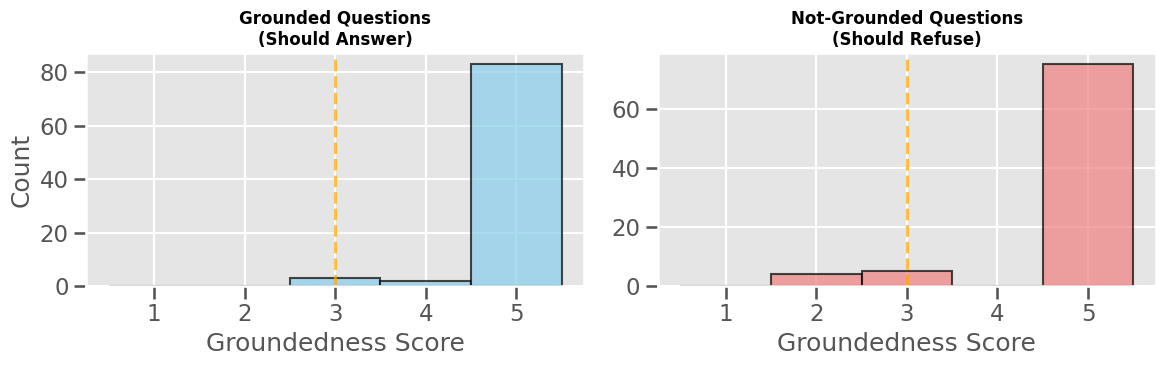

In [45]:
def plot_scores(metrics_grounded, metrics_not_grounded):
    """Simple comparison plot."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Grounded
    ax1.hist(metrics_grounded['scores'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], 
             color='skyblue', edgecolor='black', alpha=0.7)
    ax1.set_title('Grounded Questions\n(Should Answer)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Groundedness Score')
    ax1.set_ylabel('Count')
    ax1.axvline(x=3, color='orange', linestyle='--', alpha=0.7)
    
    # Not-grounded
    ax2.hist(metrics_not_grounded['scores'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5],
             color='lightcoral', edgecolor='black', alpha=0.7)
    ax2.set_title('Not-Grounded Questions\n(Should Refuse)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Groundedness Score')
    ax2.axvline(x=3, color='orange', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

plot_scores(metrics_grounded, metrics_not_grounded)

## **Error Analysis**

In [46]:
def find_poor_scores(predictions, test_data, threshold=3):
    """Find samples with poor scores (<3)."""
    poor = []
    for i, pred in enumerate(predictions):
        score = pred["result"]["groundedness"]
        if score < threshold:
            poor.append({
                "score": score,
                "question": test_data.iloc[i]["synthetic_question"],
                "response": test_data.iloc[i]["completion_response"],
                "reason": pred["result"]["groundedness_reason"],
                "domain": test_data.iloc[i]["domain"],
                "difficulty": test_data.iloc[i]["difficulty"],
                "synthetic_question_embedding": test_data.iloc[i]["synthetic_question_embedding"],
            })
    return pd.DataFrame(poor) if poor else pd.DataFrame()

# Find failures (same logic for both types - low scores = failures)
failures_grounded = find_poor_scores(predictions_grounded, df_grounded)
failures_not_grounded = find_poor_scores(predictions_not_grounded, df_not_grounded)

print(f"\n❌ Grounded failures: {len(failures_grounded)}/{len(predictions_grounded)}")
print(f"❌ Not-grounded failures: {len(failures_not_grounded)}/{len(predictions_not_grounded)}")

if len(failures_grounded) > 0:
    print(f"\nExample grounded failure:")
    print(failures_grounded.iloc[0][['score', 'question', 'response', 'reason']])
    
if len(failures_not_grounded) > 0:
    print(f"\nExample not-grounded failure:")
    print(failures_not_grounded.iloc[0][['score', 'question', 'response', 'reason']])


❌ Grounded failures: 0/88
❌ Not-grounded failures: 4/84

Example not-grounded failure:
score                                                     2.0
question    Vilka återvinningsmöjligheter finns för TrailW...
response    I don't have enough information in the provide...
reason      The response is related to the topic and conte...
Name: 0, dtype: object


In [47]:
for idx, row in failures_not_grounded.iterrows():
    print(f"Question: {row['question']}")
    print(f"Response: {row['response']}")
    print(f"Reason: {row['reason']}")
    print("\n--------------------------------\n")

Question: Vilka återvinningsmöjligheter finns för TrailWalker Hiking Shoes?
Response: I don't have enough information in the provided context to answer this question.
Reason: The response is related to the topic and context but does not answer the specific query about recycling options; it simply states that the information is not available.

--------------------------------

Question: Can I purchase replacement parts for the MountainDream Sleeping Bag, such as drawcords or zipper pulls?
Response: I don't have enough information in the provided context to answer this question.
Reason: The response is relevant and accurate given the context, but it does not answer the query, as no information is available. This matches the definition for Groundedness: 2 (Related Topic but Does Not Respond to the Query).

--------------------------------

Question: Vilka återförsäljare säljer TrekReady Hiking Boots online?
Response: I don't have enough information in the provided context to answer this q

In [48]:
# from azure.core.credentials import AzureKeyCredential
# from utils.search import get_chunk
# import os
# import dotenv

# dotenv.load_dotenv(".env", override=True)
# search_key = os.getenv("SEARCH_KEY")
# search_credential = AzureKeyCredential(search_key)

# for idx, row in df_grounded.iterrows():
#     print(f"Score: {}")
#     print(f"Synthetic Question: {row['synthetic_question']}")
#     print(f"Rag Response: {row['completion_response']}")
#     chunk_title = get_chunk(
#         os.getenv('SEARCH_INDEX_NAME'),
#         row['chunk_id'],
#         os.getenv('SEARCH_ENDPOINT'),
#         search_credential, ['title']
#     )
#     print(f"title: {chunk_title}")
#     print("--------------------------------------")
#     print()
#     print()

In [49]:
# for idx, row in df_not_grounded.iterrows():
#     print(f"Synthetic Question: {row['synthetic_question']}")
#     print(f"Rag Response: {row['completion_response']}")
#     chunk_title = get_chunk(
#         os.getenv('SEARCH_INDEX_NAME'),
#         row['chunk_id'],
#         os.getenv('SEARCH_ENDPOINT'),
#         search_credential, ['title']
#     )
#     print(f"title: {chunk_title}")
#     print("--------------------------------------")
#     print()
#     print()